**Installation of SimPy""
If not available**

In [1]:
#!pip install simpy

**Import of required modules**

In [ ]:
import simpy
import numpy as np
import numpy.random as random

: 

**Parameters settings**

In [ ]:
MAXSIMTIME = 50000
VERBOSE = False
LAMBDA = 3.8
MU = 8.0
POPULATION = 50000000
SERVICE_DISCIPLINE = 'SJF'
LOGGED = True
PLOTTED = True

: 

**Discrete-Event Simulation model**


**The definition of a job**.

The properties of a job are


1. job execution time
2. job arrival time

In [4]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

**Disciplines**
Different queue disciplines can be defined here.


1.   Shortest Job First (SJF)
2.   List item



In [5]:
def SJF( job ):
    return job.duration

**The definition of server**

 There are 2 arguments needed for a server:
 1. env: SimPy environment
 2. queue discipline: 
   - FIFO: First In First Out
   - SJF : Shortest Job First

In [6]:
class Server:
    def __init__(self, env, strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        ''' statistics '''
        self.waitingTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        ''' register a new server process '''
        env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.serversleeping = env.process( self.waiting( self.env ))
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )
                if LOGGED:
                    qlog.write( '%.4f\t%d\t%d\n' 
                        % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)) )

                ''' sum up the waiting time'''
                self.waitingTime += self.env.now - j.arrtime
                ''' yield an event for the job finish'''
                yield self.env.timeout( j.duration )
                ''' sum up the jobs done '''
                self.jobsDone += 1

    def waiting(self, env):
        try:
            if VERBOSE:
                print( 'Server is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                print('Server waken up and works at %.2f' % self.env.now )

**The arrival process**

The arrival process is exponentially distributed which is parameterized by
1. number of servers
2. maximum number of population
3. arrival rate $\lambda$
4. service rate $\mu$
*Note that, the implementation of the arrival process embeds both arrival and service distributions.*

In [7]:
class JobGenerator:
    def __init__(self, env, server, nrjobs = 10000000, lam = 5, mu = 8):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam;
        self.servicetime = 1/mu;
        env.process( self.generatejobs(env) )
        
    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            self.server.Jobs.append( Job('Job %s' %i, env.now, job_duration) )
            if VERBOSE:
                print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    %( i, env.now, job_duration, job_interarrival ) )
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt( 'Wake up, please.' )


**Open the log file**

If requested.

In [8]:
if LOGGED:
    qlog = open( 'mm1-l%d-m%d.csv' % (LAMBDA,MU), 'w' )
    qlog.write( '0\t0\t0\n' )

**Start SimPy environment**

In [9]:
env = simpy.Environment()
MyServer = Server( env, SERVICE_DISCIPLINE )
MyJobGenerator = JobGenerator( env, MyServer, POPULATION, LAMBDA, MU )

**Run the simulation** 

In [10]:
env.run( until = MAXSIMTIME )

**Close the log file**

In [11]:
if LOGGED:
    qlog.close()

**Print some statistics**

In [12]:
RHO = LAMBDA/MU
print( 'Arrivals               : %d' % (MyServer.jobsDone) )
print( 'Utilization            : %.2f/%.2f' 
    % (1.0-MyServer.idleTime/MAXSIMTIME, RHO) )
print( 'Mean waiting time      : %.2f/%.2f' 
    % (MyServer.waitingTime/MyServer.jobsDone, RHO**2/((1-RHO)*LAMBDA) ) )

Arrivals               : 190518
Utilization            : 0.48/0.47
Mean waiting time      : 0.08/0.11


**Plot the statistics**

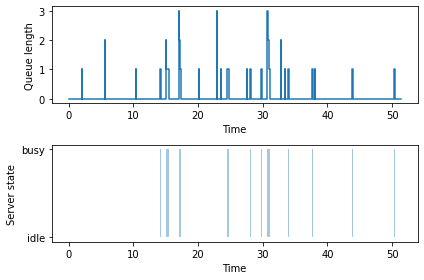

In [13]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'mm1-l%d-m%d.csv' % (LAMBDA,MU), delimiter = '\t' )
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    #plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()